In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

<Axes: xlabel='median_house_value', ylabel='Count'>

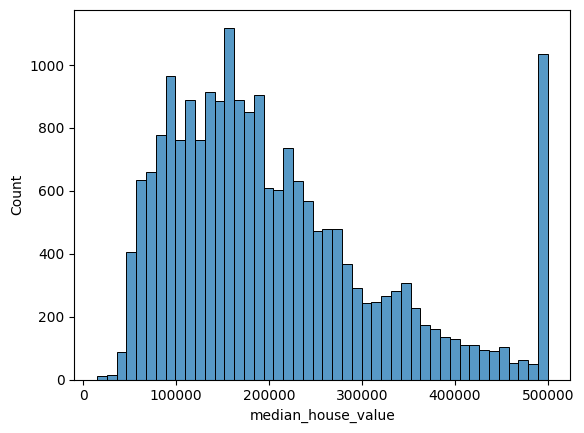

In [7]:
data = pd.read_csv("./housing.csv")
sns.histplot(data['median_house_value'])

## Preparing the dataset

In [8]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
near_ocean_houses = data[data['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
features = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
new_data = near_ocean_houses[features]

## Question 1
There's one feature with missing values. What is it? `total_bedrooms`

In [10]:
new_data.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Question 2
What's the median (50% percentile) for variable 'population'? 1195

In [11]:
new_data['population'].median()

1195.0

Preparing and splitting the dataset

In [12]:
np.random.seed(42)
shuffled_data = new_data.sample(frac=1)
shuffled_data

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
19963,36.23,-119.14,22.0,2935.0,523.0,1927.0,530.0,2.5875,70400.0
5929,34.12,-117.79,16.0,2426.0,426.0,1319.0,446.0,4.8125,224500.0
11377,33.68,-117.97,26.0,3653.0,568.0,1930.0,585.0,5.7301,260900.0
6443,34.10,-118.03,32.0,2668.0,609.0,1512.0,541.0,2.9422,233100.0
17546,37.34,-121.87,39.0,2479.0,541.0,1990.0,506.0,2.4306,289100.0
...,...,...,...,...,...,...,...,...,...
6651,34.15,-118.14,41.0,1256.0,407.0,855.0,383.0,1.9923,500001.0
17810,37.40,-121.86,19.0,4043.0,764.0,2196.0,708.0,6.1504,268400.0
6850,34.07,-118.15,52.0,1983.0,344.0,887.0,331.0,3.2875,234400.0
2161,36.78,-119.81,37.0,1965.0,364.0,796.0,335.0,3.6250,83400.0


In [13]:
train_ratio = 0.6
test_ratio = 0.2
val_ratio = 0.2

train_data, val_data, test_data = np.split(shuffled_data, [int(train_ratio * len(shuffled_data)), int((train_ratio + val_ratio) * len(shuffled_data))])

y_train = np.log1p(train_data['median_house_value'])
y_val = np.log1p(val_data['median_house_value'])
y_test = np.log1p(test_data['median_house_value'])

## Question 3
Answer: Both are equally good

In [14]:
train_df_filled_mean = train_data.copy()
train_df_filled_mean['total_bedrooms'].fillna(train_data['total_bedrooms'].mean(), inplace=True)
train_df_with_zeros = train_data.copy()
train_df_with_zeros['total_bedrooms'].fillna(0, inplace=True)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    error = y - y_pred
    mse = (error ** 2).mean()
    return np.sqrt(mse)

0.17

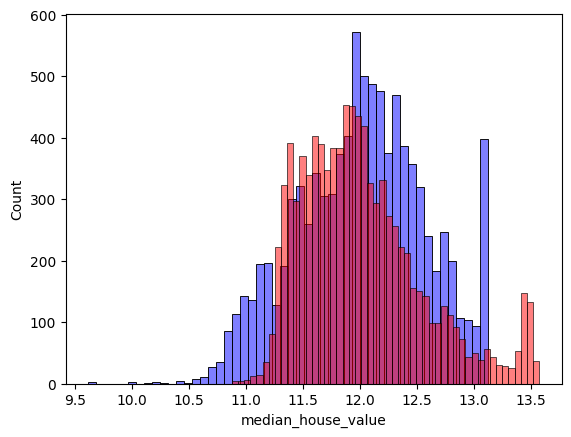

In [15]:
w0, w = train_linear_regression(train_df_filled_mean, y_train)
y_pred_with_mean = w0 + train_df_filled_mean.values.dot(w)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)
sns.histplot(y_pred_with_mean, color='red', alpha=0.5, bins=50)
score = rmse(y_train, y_pred_with_mean)
round(score, 2)

0.17

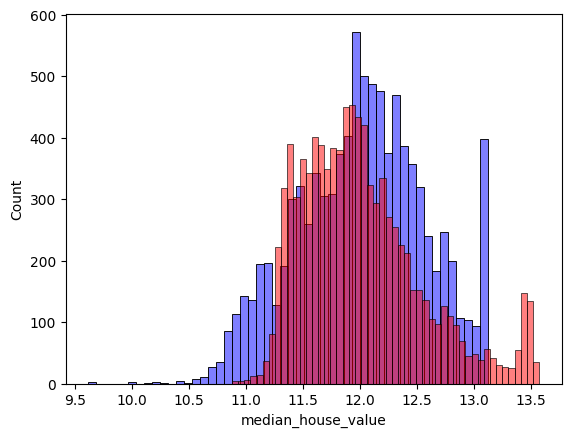

In [16]:
w0, w = train_linear_regression(train_df_with_zeros, y_train)
y_pred_with_zeros = w0 + train_df_with_zeros.values.dot(w)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)
sns.histplot(y_pred_with_zeros, color='red', alpha=0.5, bins=50)
score = rmse(y_train, y_pred_with_zeros)
round(score, 2)

In [17]:
def prepare_X(X):
    X['total_bedrooms'].fillna(0, inplace=True)
    return X

def split_and_shuffle(X,seed):
    init_size = len(new_data)
    test_size = int(init_size * 0.2)
    val_size = int(init_size * 0.2)
    train_size = init_size - test_size - val_size

    idx = np.arange(init_size)
    np.random.seed(seed)
    np.random.shuffle(idx)
    train_df = new_data.iloc[idx[train_size:]]
    val_df = new_data.iloc[idx[train_size: train_size + val_size]]
    test_df = new_data.iloc[idx[train_size + val_size:]]

    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    y_train = np.log1p(train_df['median_house_value'].values)
    y_val = np.log1p(val_df['median_house_value'].values)
    y_test = np.log1p(test_df['median_house_value'].values)

    return train_df, val_df, test_df, y_train, y_val, y_test

## Question 4
Answer: 0 (nearest)

In [18]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

seed = 42
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X = new_data.copy()
    X_train, X_val, X_test, y_train, y_val, y_test = split_and_shuffle(X,seed)
    X_train = prepare_X(X_train)
    w0, w = train_linear_regression_reg(X_train,y_train,r)
    X_val = prepare_X(X_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_test, y_pred)
    print("R value %s has RMSE of %s"% (r, round(score, 2)))

R value 0 has RMSE of 0.79
R value 1e-06 has RMSE of 0.79
R value 0.0001 has RMSE of 0.79
R value 0.001 has RMSE of 0.79
R value 0.01 has RMSE of 0.79
R value 0.1 has RMSE of 0.79
R value 1 has RMSE of 0.79
R value 5 has RMSE of 0.79
R value 10 has RMSE of 0.79


## Question 5
Answer = 0.005 (nearest)

In [19]:
scores = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    X = new_data.copy()
    X_train, X_val, X_test, y_train, y_val, y_test = split_and_shuffle(X,seed)
    X_train = prepare_X(X_train)
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_train.dot(w)
    score = rmse(y_train,y_pred)
    scores.append(score)

round(np.array(scores).std(),3)

0.002

## Question 6
Answer: 0.13 (nearest)

In [20]:
X = new_data.copy()
seed = 9
X_train, X_val, X_test, y_train, y_val, y_test = split_and_shuffle(X,seed)
X_train = pd.concat([X_train,X_val])
X_train.reset_index(drop=True)
y_train = np.concatenate([y_train,y_val])
X_train = prepare_X(X_train)
w0, w = train_linear_regression_reg(X_train, y_train, 0.001)
X_test = prepare_X(X_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test,y_pred)
round(score, 2)

0.17